参考：[知乎](https://zhuanlan.zhihu.com/p/73930638?from_voters_page=true)

In [1]:
import pandas
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random

In [2]:
dataset=pandas.read_excel('Case.xlsx',sheet_name='initial')

data =dataset.values

X =data[:,1:18] #不包括18列-维持时间
Y =data[:,19]
validation_size = 0.2
seed = random.randint(0,1000)
X_train, X_test,y_train,y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [3]:
from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

#安装第三方库
import sys
!{sys.executable} -m pip install minisom

In [4]:
from minisom import MiniSom
import math  #math.ceil()返回数字的上入整数

N = X_train.shape[0]  #样本数量
M = X_train.shape[1]  #维度/特征数量

'''
设置超参数
'''
size = math.ceil(np.sqrt(5 * np.sqrt(N)))  # 经验公式：决定输出层尺寸
print("训练样本个数:{}  测试样本个数:{}".format(N,X_test.shape[0]))
print("输出网格最佳边长为:",size)

max_iter = 200

# Initialization and training
som = MiniSom(size, size, M, sigma=3, learning_rate=0.5, 
              neighborhood_function='bubble')

训练样本个数:3576  测试样本个数:488
输出网格最佳边长为: 18


neighborhood_function:<p>
    'gaussian'<p>
    'mexican_hat'<p>
    'bubble': 计算速度比高斯快，优胜领域是一圈一圈的，调sigma取值范围缩小很多（只能选离散值），例如sigma=2.5，表示优胜节点及其周围2圈神经元
<p>learning_rate：默认0.5，大部分情况都适用

In [5]:
'''
初始化权值，有2个API
'''
#som.random_weights_init(X_train)
som.pca_weights_init(X_train)

网络训练之前，需要初始化权重；之前的文章提到过，有三种初始化方法，这里却只提供了2个函数。因为创建som实例的时候，就已经默认使用了Random Init(权重初始化为随机数)

一般优先考虑pca_weights_init和random_weights_init，其中pca初始化的结果时固定的，也就是说网络初始状态是固定的，而random_weights_init带有一定随机性

In [6]:
#开始训练
som.train_batch(X_train, max_iter, verbose=False)
#som.train_random(X_train, max_iter, verbose=False)

train_random 每轮迭代随机挑选一个样本来更新权重，直到迭代次数满足max_iter

train_batch 每次按顺序取一个样本，用过最后一个样本后跳回第一个样本，循环直到迭代次数满足max_iter

In [7]:
#分类
winmap = som.labels_map(X_train,y_train)

abels_map利用标签信息，标注训练好的Som网络：

Som网络一大特点就是保留输入空间中的拓扑结构，那么输入空间中邻近的样本数据会落到相邻的神经元中。我们计算每一个输入样本对应的优胜节点的位置，即输出平面中哪一个神经元计算完所有的训练样本后，我们统计平面中每个神经元的类别个数(这里就用到了标签信息)，例如 某神经元有5个样本能激活它，其中4个属于A类 1个属于B类.

简单的方法，我们可以取频率最高的类别，作为该神经元的类别标签；或许，你也可以用各个类的频率估计概率密度



当新的样本(unseen data)落入输出平面的某个神经元时，我们就可以判断样本的类别了！

In [8]:
#如果miniSom库的som.classify报错，复制源代码修改得：
def classify(som,data,winmap):
    from numpy import sum as npsum
    default_class = npsum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result
#这个函数传入训练好的模型som，待预测的测试样本data向量(可包含多个样本)，之前标好标签的winmap。

In [9]:
#无监督训练出的模型，在测试集上的效果
# 输出混淆矩阵
y_pred = classify(som,X_test,winmap)
print(classification_report(y_test, np.array(y_pred)))

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

cm = confusion_matrix(y_test,y_pred)
TP=cm[1][1]
TN=cm[0][0]
FP=cm[0][1]
FN=cm[1][0]

print(cm)
print("CSI: {:.3f}".format(TP/(TP+FP+FN)))
print('HSS: {:.3f}'.format((TP*TN-FN*FP)/((TP+FN)*(FN+TN)+(TP+FP)*(FP+TN))))

              precision    recall  f1-score   support

         0.0       0.96      0.53      0.68       459
         1.0       0.08      0.66      0.14        29

    accuracy                           0.54       488
   macro avg       0.52      0.59      0.41       488
weighted avg       0.91      0.54      0.65       488

[[244 215]
 [ 10  19]]
CSI: 0.078
HSS: 0.022


In [10]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print("AUC for eec: {:.3f}".format(auc))

AUC for eec: 0.593


### 可视化 

#### U-Matrix

根据权重矩阵W,我们可以计算每个神经元 距离它的邻近神经元们的距离，计算好的矩阵就是U-Matrix

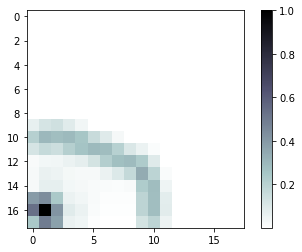

In [11]:
heatmap = som.distance_map()  #生成U-Matrix
plt.imshow(heatmap, cmap='bone_r')      #miniSom案例中用的pcolor函数,需要调整坐标
plt.colorbar()

在输出层画标签图案

希望看一看训练样本分别都落在输出层的哪些格子，并且希望看到他们的标签信息

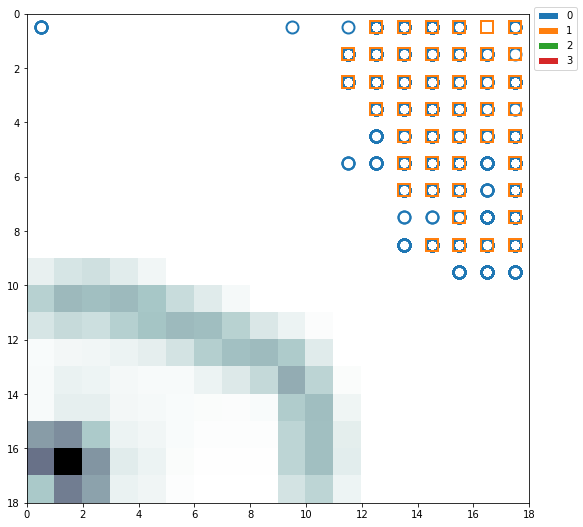

In [12]:
plt.figure(figsize=(9, 9))
# 背景上画U-Matrix
heatmap = som.distance_map()
plt.pcolor(heatmap, cmap='bone_r')  # plotting the distance map as background

# 定义不同标签的图案标记
markers = ['o', 's', 'D','x']
colors = ['C0', 'C1', 'C2','C3']
category_color = {'0': 'C0',
                  '1': 'C1',
                  '2': 'C2',
                 '3':'C3'}
for cnt, xx in enumerate(X_train):   #enumerate()枚举函数
    w = som.winner(xx)  # getting the winner
    # 在样本Heat的地方画上标记
    plt.plot(w[0]+0.5, w[1]+0.5, markers[int(y_train[cnt])], markerfacecolor='None',
             markeredgecolor=colors[int(y_train[cnt])], markersize=12, markeredgewidth=2)
plt.axis([0, size, 0, size])
ax = plt.gca()
ax.invert_yaxis() #颠倒y轴方向
legend_elements = [Patch(facecolor=clr,
                         edgecolor='w',
                         label=l) for l, clr in category_color.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .95))
plt.show()

问题：

不清楚每个格子的样本数量

如果有个类别落到同一个格子，看不出比例

#### 饼图

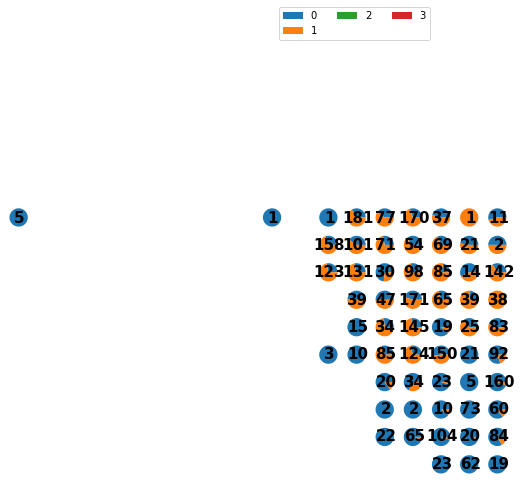

In [13]:
label_name_map_number = {"0":0,"1":1,"2":2,"3":3}

from matplotlib.gridspec import GridSpec

plt.figure(figsize=(9, 9))
the_grid = GridSpec(size, size)

for position in winmap.keys():
    label_fracs = [winmap[position][label] for label in [0,1,2,3]]
    plt.subplot(the_grid[position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
    plt.text(position[0]/100, position[1]/100,  str(len(list(winmap[position].elements()))),
              color='black', fontdict={'weight': 'bold',  'size': 15},
              va='center',ha='center')
plt.legend(handles=patches , labels=['0','1','2','3'] , loc='center right', bbox_to_anchor=(-1,9), ncol=3)
plt.show()

能够清晰的看出，每个位置由多少个样本落在其中，且如果有多个类别时也可以看到他们的比例

#### Component Plane

In [14]:
#Component Plane每个神经元对单个特征什么取值最敏感
plt.figure(figsize=(10, 10))
W=som.get_weights() #Weight权值矩阵，是一个维度为(size X size X 特指数)的矩阵
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.imshow(W[:,:,i], cmap='coolwarm')
    #W[:,:,i]取出特征i对应的权值矩阵
    #这个取值就表示每个位置的神经元对什么取值最敏感(或者理解为与该特征取值最匹配
    plt.colorbar()
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
#plt.tight_layout()
plt.show()

NameError: name 'feature_names' is not defined

<Figure size 720x720 with 0 Axes>